In [80]:
import pandas as pd
import numpy as np
import os, random

import matplotlib.pyplot as plt
import cv2 as cv
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [127]:
label_class = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}
class_label = {v: k for k, v in label_class.items()}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [82]:
train_base_path = 'images/train/'
val_base_path = 'images/validation/'

classes = list(label_class.values())
train_paths = [train_base_path + each_class for each_class in classes]
val_paths = [val_base_path + each_class for each_class in classes]

In [83]:
def load_data(addr, classes_dict):
        
    imgs = []
    
    for paths in addr:
        mood_class = paths.split('/')[-1]
        samples = os.listdir(paths)
        for i, each_sample in enumerate(samples):
            imgs.append((cv.cvtColor(cv.imread(paths + '/' + each_sample), cv.COLOR_BGR2GRAY), classes_dict[mood_class]))

    random.shuffle(imgs)
            
    return np.array([each[0] for each in imgs]), np.array([each[1] for each in imgs])

In [84]:
tr_data, tr_lbls = load_data(train_paths, class_label)
val_data, val_lbls = load_data(val_paths, class_label)

In [85]:
tr_data.shape

(28821, 48, 48)

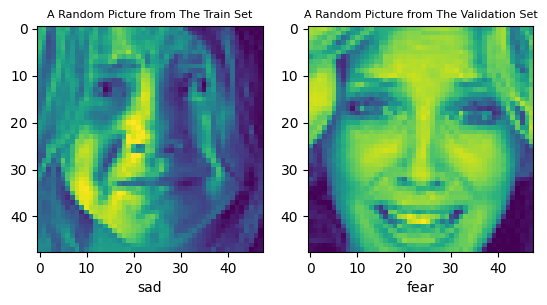

In [86]:
tr_idx = random.randint(0, tr_data.shape[0])
val_idx = random.randint(0, val_data.shape[0])
img1 = tr_data[tr_idx]
lbl1 = tr_lbls[tr_idx]
img2 = val_data[val_idx]
lbl2 = val_lbls[val_idx]

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel(label_class[lbl1])
ax1.set_title('A Random Picture from The Train Set', fontsize=8)
ax2.set_xlabel(label_class[lbl2])
ax2.set_title('A Random Picture from The Validation Set', fontsize=8)

ax1.imshow(img1)
ax2.imshow(img2)

In [87]:
tr_tensor = torch.from_numpy(tr_data) / 255
val_tensor = torch.from_numpy(val_data) / 255
tr_lbl_tensor = torch.from_numpy(tr_lbls) / 255
val_lbl_tensor = torch.from_numpy(val_lbls) / 255

In [88]:
m, w, h = tr_tensor.shape 
tr_tensor = tr_tensor.reshape((m, 1, w, h))

m, w, h = val_tensor.shape 
val_tensor = val_tensor.reshape((m, 1, w, h))

In [89]:
tr_tensor.shape

torch.Size([28821, 1, 48, 48])

In [90]:
val_tensor.shape

torch.Size([7066, 1, 48, 48])

In [133]:
tr_loader = DataLoader(list(zip(tr_tensor, tr_lbl_tensor)), shuffle=True, batch_size=64)
val_loader = DataLoader(list(zip(val_tensor, val_lbl_tensor)), shuffle=True, batch_size=64)

In [141]:
class Model(nn.Module):
    def __init__(self, num_features):
        
        super(Model, self).__init__()
        
        self.conv1 = nn.Conv2d(num_features, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 5)
        # self.conv3 = nn.Conv2d(64, 128, 5, padding='same')
        self.fc1 = nn.Linear(16 * 9 * 9, 128, True)
        self.fc2 = nn.Linear(128, 64, True)
        self.fc3 = nn.Linear(64, 7, True)
        self.pool = nn.MaxPool2d(2, 2)
        # self.batch1 = nn.BatchNorm2d(64)
        # self.batch2 = nn.BatchNorm2d(128)
        # self.batch3 = nn.BatchNorm2d(512)
        self.act1 = nn.ReLU()
        # self.act2 = nn.Softmax()
        self.dropout1 = nn.Dropout2d(0.5)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout2d(0.5)
        self.flat = nn.Flatten()


    
    def forward(self, x):

        # print(x.shape)
        x = self.dropout1(self.pool(self.act1(self.conv1(x))))
        # print(x.shape)
        x = self.dropout2(self.pool(self.act1(self.conv2(x))))
        # print(x.shape)
        # x = self.dropout3(self.pool(self.act1(self.conv3(x))))
        # print(x.shape)

        x = self.flat(x)
        # print(x.shape)
        x = self.act1(self.fc1(x))
        x = self.act1(self.fc2(x))
        x = self.fc3(x)

        return x

In [144]:
model = Model(1).to(device)

opt = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [145]:
EPOCH = 10
history = []

for epoch in range(EPOCH):
    total_loss = 0.0
    
    for imgs, lbls in tr_loader:

        imgs = imgs.to(device)
        lbls = lbls.to(device)
        
        opt.zero_grad()
        logits = model(imgs)
        # print(logits.shape)
        batch_loss = criterion(logits, lbls.long())
        batch_loss.backward()
        opt.step()
        
        total_loss += batch_loss.item()
        history.append(batch_loss.item())
        
    print('Epoch [{}/{}] loss: '.format(epoch + 1, EPOCH), total_loss)

Epoch [1/10] loss:  7.880446705782069
Epoch [2/10] loss:  0.015026901233849865
Epoch [3/10] loss:  0.02350631628750155
Epoch [4/10] loss:  0.020029136444680296
Epoch [5/10] loss:  0.014691110625665305
Epoch [6/10] loss:  0.01575899806645864
Epoch [7/10] loss:  1.1239187386991034e-05
Epoch [8/10] loss:  1.1809435556120462e-05
Epoch [9/10] loss:  0.003667663291590628
Epoch [10/10] loss:  0.0026192434547027688
